In [1]:
import pandas as pd
import numpy as np
import json
from sklearn.preprocessing import StandardScaler
from keras.models import Sequential
from keras.layers import Dense
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from bs4 import BeautifulSoup as bs
import seaborn as sns
import requests
from numpy import base_repr

c:\Users\henry\miniconda3\lib\site-packages\scipy\__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [33]:
# df = pd.read_csv('https://raw.githubusercontent.com/JeffSackmann/tennis_atp/master/atp_matches_2022.csv')
df = pd.read_csv('https://raw.githubusercontent.com/JeffSackmann/tennis_atp/master/atp_matches_qual_chall_2022.csv')
dff = pd.read_csv('https://raw.githubusercontent.com/JeffSackmann/tennis_atp/master/atp_matches_2022.csv')
df = pd.concat([df, dff])
winner = ['p1_id', 'p1_hand', 'p1_ht', 'p1_age', 'p1_ace', 'p1_df', 'p1_svpt', 'p1_1stIn', 'p1_1stWon', 'p1_2ndWon', 'p1_SvGms', 'p1_bpSaved', 'p1_bpFaced', 'p1_rank']
loser = ['p2_id', 'p2_hand', 'p2_ht', 'p2_age', 'p2_ace', 'p2_df', 'p2_svpt', 'p2_1stIn', 'p2_1stWon', 'p2_2ndWon', 'p2_SvGms', 'p2_bpSaved', 'p2_bpFaced', 'p2_rank']

def process_data(df):
    #drop winner/loser entry, can replace with var later
    df = df.drop(columns = ['winner_entry', 'loser_entry', 'winner_rank_points', 'loser_rank_points', 'best_of', 'minutes', 'tourney_id', 'tourney_name', 'tourney_level', 'winner_ioc', 'loser_ioc', 'score', 'round', 'draw_size', 'tourney_date', 'match_num'])
    df = df.drop(columns = ['winner_seed', 'loser_seed'])

    #if winner_rank, loser_rank == null, then _rank = 2000
    df['winner_rank'] = df['winner_rank'].fillna(2000)
    df['loser_rank'] = df['loser_rank'].fillna(2000)
    #player height == null = 183cm
    df['winner_ht'] = df['winner_ht'].fillna(183)
    df['loser_ht'] = df['loser_ht'].fillna(183)

    df = df.dropna(axis = 0)

    #dropping for the simplicitty for future match data as surface is unknown
    df = df.drop(columns = ['surface'])
    # df.loc[df["surface"] == "Hard", "surface"] = 1.0
    # df.loc[df["surface"] == "Clay", "surface"] = 2.0
    # df.loc[df["surface"] == "Grass", "surface"] = 3.0
    # df.loc[df["surface"] == "Carpet", "surface"] = 3.0

    df.loc[df["winner_hand"] == "R", "winner_hand"] = 1.0
    df.loc[df["winner_hand"] == "L", "winner_hand"] = 2.0
    df.loc[df["winner_hand"] == "U", "winner_hand"] = 3.0
    df.loc[df["loser_hand"] == "R", "loser_hand"] = 1.0
    df.loc[df["loser_hand"] == "L", "loser_hand"] = 2.0
    df.loc[df["loser_hand"] == "U", "loser_hand"] = 3.0

    df_with_names = df

    df = df.drop(columns=['winner_name', 'loser_name'])

    df2 = df.rename({'winner_id':'p1_id', 'winner_seed':'p1_seed', 'winner_hand':'p1_hand', 'winner_ht':'p1_ht', 'winner_ioc':'p1_ioc', 'winner_age':'p1_age', 'w_ace':'p1_ace', 'w_df':'p1_df', 'w_svpt':'p1_svpt', 'w_1stIn':'p1_1stIn', 'w_1stWon':'p1_1stWon', 'w_2ndWon':'p1_2ndWon', 'w_SvGms':'p1_SvGms', 'w_bpSaved':'p1_bpSaved', 'w_bpFaced':'p1_bpFaced', 'winner_rank':'p1_rank',
                    'loser_id':'p2_id', 'loser_seed':'p2_seed', 'loser_hand':'p2_hand', 'loser_ht':'p2_ht', 'loser_ioc':'p2_ioc', 'loser_age':'p2_age', 'l_ace':'p2_ace', 'l_df':'p2_df', 'l_svpt':'p2_svpt', 'l_1stIn':'p2_1stIn', 'l_1stWon':'p2_1stWon', 'l_2ndWon':'p2_2ndWon', 'l_SvGms':'p2_SvGms', 'l_bpSaved':'p2_bpSaved', 'l_bpFaced':'p2_bpFaced', 'loser_rank':'p2_rank'
                    }, axis='columns')
    df2['result'] = 1

    df2 = df2.dropna()
    df2 = df2.reset_index(drop=True)
    return df2, df_with_names

df2, df_with_names = process_data(df)

# randomize the sequence of players A | B, set the result field respectively
for ind in range(len(df2)):
    if np.random.randint(2) == 1:
        df2.loc[ind, 'result'] = 0
        df2.loc[ind, winner], df2.loc[ind, loser] = df2.loc[ind, loser].values, df2.loc[ind, winner].values

In [34]:
# manually split the dataset get the indx of the split
p = 0.99
# p = 0.90
idx = int(p * df2.shape[0]) + 1
x_train, x_test = np.split(df2, [idx])

stats = ['ace', 'df', 'svpt', '1stIn', '1stWon', '2ndWon', 'SvGms', 'bpSaved', 'bpFaced']
#getting ready to construct the stats, set all fields above to 0
for i in stats:
    x_test['p1_' + i] = 0
    x_test['p2_' + i] = 0

# add match statistics, and add weight to it
def process_df(df, playerA, playerA_num, playerA_count, col, rate = 0.4): 
    playerA["ace"] += df[col[playerA_num + '_ace']]
    playerA["df"] += df[col[playerA_num + '_df']]
    playerA["svpt"] += df[col[playerA_num + '_svpt']]
    playerA["1stIn"] += df[col[playerA_num + '_1stIn']]
    playerA["1stWon"] += df[col[playerA_num + '_1stWon']]
    playerA["2ndWon"] += df[col[playerA_num + '_2ndWon']]
    playerA["SvGms"] += df[col[playerA_num + '_SvGms']]
    playerA["bpSaved"] += df[col[playerA_num + '_bpSaved']]
    playerA["bpFaced"] += df[col[playerA_num + '_bpFaced']]
    playerA_count += rate
    return playerA, playerA_count

# add stats to the empty row of testing data
def populate_df(df, df2):
    p1_id = df2.columns.tolist().index('p1_id')
    p2_id = df2.columns.tolist().index('p2_id')

    columns = df2.columns.tolist()
    col_indx = {
        "p1_ace": columns.index('p1_ace'),
        "p1_df": columns.index('p1_df'),
        "p1_svpt": columns.index('p1_svpt'),
        "p1_1stIn": columns.index('p1_1stIn'),
        "p1_1stWon": columns.index('p1_1stWon'),
        "p1_2ndWon": columns.index('p1_2ndWon'),
        "p1_SvGms": columns.index('p1_SvGms'),
        "p1_bpSaved": columns.index('p1_bpSaved'),
        "p1_bpFaced": columns.index('p1_bpFaced'),
        "p2_ace": columns.index('p2_ace'),
        "p2_df": columns.index('p2_df'),
        "p2_svpt": columns.index('p2_svpt'),
        "p2_1stIn": columns.index('p2_1stIn'),
        "p2_1stWon": columns.index('p2_1stWon'),
        "p2_2ndWon": columns.index('p2_2ndWon'),
        "p2_SvGms": columns.index('p2_SvGms'),
        "p2_bpSaved": columns.index('p2_bpSaved'),
        "p2_bpFaced": columns.index('p2_bpFaced')
    }

    indx = 0
    df.reset_index(drop=True, inplace=True)

    # convert df to numpy to decrease runtime
    for row in df.to_numpy():
        p1_stats = dict.fromkeys(stats, 0)
        p2_stats = dict.fromkeys(stats, 0)
        p1_count = 0
        p2_count = 0
        player1 = row[df.columns.tolist().index('p1_id')]
        player2 = row[df.columns.tolist().index('p2_id')]
        for r in df2.to_numpy():
            if(r[p1_id] == player1 and r[p2_id] != player2):
                p1_stats, p1_count = process_df(r, p1_stats, 'p1', p1_count, col_indx)
            elif(r[p2_id] == player1 and r[p1_id] != player2):
                p1_stats, p1_count = process_df(r, p1_stats, 'p2', p1_count, col_indx)
            if(r[p1_id] == player2 and r[p2_id] != player1):
                p2_stats, p2_count = process_df(r, p2_stats, 'p1', p2_count, col_indx)
            elif(r[p2_id] == player2 and r[p1_id] != player1):
                p2_stats, p2_count = process_df(r, p2_stats, 'p2', p2_count, col_indx)
            if(r[p1_id] == player1 and r[p2_id] == player2):
                p1_stats, p1_count = process_df(r, p1_stats, 'p1', p1_count, col_indx, 0.6)
                p2_stats, p2_count = process_df(r, p2_stats, 'p2', p2_count, col_indx, 0.6)
            elif(r[p1_id] == player2 and r[p2_id] == player1):
                p1_stats, p1_count = process_df(r, p1_stats, 'p2', p1_count, col_indx, 0.6)
                p2_stats, p2_count = process_df(r, p2_stats, 'p1', p2_count, col_indx, 0.6)
        for i in stats:
            if p1_count == 0:
                p1_count += 1
            if p2_count == 0:
                p2_count += 1
            df.loc[indx, ('p1_' + i)] = p1_stats[i]/p1_count
            df.loc[indx, ('p2_' + i)] = p2_stats[i]/p2_count
        indx += 1
    return df

x_test = populate_df(x_test, x_train)

#split x & y value and get the data ready for training
x_train = df2.values[:, :-2]
y_train = df2.values[:, -1]
y_test = x_test.values[:, -1]
x_test = x_test.values[:, :-2]
x_test = np.asarray(x_test).astype('float32')
x_train = np.asarray(x_train).astype('float32')
y_test = np.asarray(y_test).astype('float32')
y_train = np.asarray(y_train).astype('float32')
sc = StandardScaler()
sc.fit(x_train)
x_train = sc.transform(x_train)
x_test = sc.transform(x_test)


In [52]:
def train_model(x_train, y_train):
    model = Sequential()
    model.add(Dense(np.shape(x_train)[1], kernel_initializer='uniform', activation='relu'))
    model.add(Dense(37, activation='relu', name='dense2'))
    model.add(Dense(37, activation='relu', name='dense3'))
    model.add(Dense(units=1, activation='sigmoid'))
    model.compile(loss='binary_crossentropy', optimizer='adam',
                  metrics=['accuracy'])
    # model.fit(x_train, y_train, epochs=100, batch_size=20)
    model.fit(x_train, y_train, epochs=35, batch_size=10, verbose=0)
    # model.fit(x_train, y_train, epochs=20, batch_size=10)
    return model
model = train_model(x_train, y_train)
    

In [36]:
yhat = (model.predict(x_test, verbose=0) > 0.5).astype(int)
matr = confusion_matrix(y_test, yhat)
from sklearn.metrics import f1_score
print("F1-score: ", f1_score(y_test,yhat))
print(matr)

F1-score:  0.6511627906976745
[[36 19]
 [26 42]]


In [54]:
# get api data from server
url = 'https://tnnz.io/api_web?mode=matches_daily&date=2022-12-08&timezone=America%2FNew_York&language=en&platform=web&version=100&subscribed=%7B%7D&favorites=%7B%7D&theme_settings=%7B%7D'
data = requests.get(url).json()
# f = open('app/match_prediction.json')
# data = json.load(f)

In [55]:
# getting index of the player, name, score, and title location and convert int -> base36 and then lower case it
playeridx = base_repr(data['K'].index('players'), 36).lower()
nameidx = base_repr(data['K'].index('name'), 36).lower()
scoreidx = base_repr(data['K'].index('scores'), 36).lower()
title = base_repr(data['K'].index('title'), 36).lower()

In [56]:
# iter through the json response and get the matches of the day and store in to a dataframe [player1, player2, result]
dfa = pd.DataFrame(columns=['p1', 'p2', 'result'])
for i in range(len(data["_"]["0"]["1"])):
    for j in range(len(data["_"]["0"]["1"][i]["0"])):
        # print(data["_"]["0"]["1"][i]["0"][j]["7"][1])
        p1 = data["_"]["0"]["1"][i]["0"][j][str(playeridx)][0][nameidx]
        p2 = data["_"]["0"]["1"][i]["0"][j][str(playeridx)][1][nameidx]
        try:
            a, b = 0, 0
            for z in range(len(data["_"]["0"]["1"][i]["0"][j][scoreidx])):
                # print(data["_"]["0"]["1"][i]["0"][j]["d"][z])
                if(data["_"]["0"]["1"][i]["0"][j][scoreidx][z][0]['e'] > data["_"]["0"]["1"][i]["0"][j][scoreidx][z][1]['e']):
                    a += 1
                else:
                    b += 1
            if(a > b):
                result = 1
            else:
                result = 0
        except:
            result = -1
        dfa.loc[len(dfa.index)] = [p1, p2, result] 

# names are encoded, and we get the string by calling another part of the json file with the code decoded from base36 -> base10
dfb = dfa
dfb['p1'] = dfa['p1'].apply(lambda x: data["P"][int(x[2:], 36)] if x[0]=='p' else x)
dfb['p2'] = dfa['p2'].apply(lambda x: data["P"][int(x[2:], 36)] if x[0]=='p' else x)

In [57]:
pd_columns = df2.columns
df_future = pd.DataFrame(columns=pd_columns)
df_player_name_id = pd.DataFrame(columns=['first', 'last', 'id'])

# we now populate the new matches with the datas from the training data, these are data that are set and not change, such as playerid, handedness
# height and age. For the sake of simplicty, for age, we iter through the list backwards to get the latest match the player has played and use that
# age
for i, row in dfb.iterrows():
    p1_first = row['p1'].split(" ")[0]
    p1_last = row['p1'].split(" ")[-1]
    p2_first = row['p2'].split(" ")[0]
    p2_last = row['p2'].split(" ")[-1]
    match_result = row['result']
    def id_search(first, last):
        for j, r in df_with_names[::-1].iterrows():
            playerid, hand, ht, age, rank = '', '', '', '', ''
            if first in r['winner_name'] and last in r['winner_name']:
                playerid = r['winner_id']
                hand = r['winner_hand']
                ht = r['winner_ht']
                age = r['winner_age']
                rank = r['winner_rank']
                break
            elif first in r['loser_name'] and last in r['loser_name']:
                playerid = r['loser_id']
                hand = r['loser_hand']
                ht = r['loser_ht']
                age = r['loser_age']
                rank = r['loser_rank']
                break
        df_player_name_id.loc[len(df_player_name_id)] = [first, last, playerid]
        return [playerid, hand, ht, age, rank]

    p1_info, p2_info = id_search(p1_first, p1_last), id_search(p2_first, p2_last)
    if(p1_info[0] != '' and p2_info[0] != ''):
        new_row = pd.DataFrame({'p1_id': p1_info[0], 'p1_hand': p1_info[1], 'p1_ht': p1_info[2], 'p1_age': p1_info[3], 'p1_rank': p1_info[4], 'p2_id': p2_info[0], 'p2_hand': p2_info[1], 'p2_ht': p2_info[2], 'p2_age': p2_info[3], 'p2_rank': p2_info[4], 'result': match_result}, index=[0])
        df_future = pd.concat([new_row,df_future.loc[:]]).reset_index(drop=True)
        df_future = df_future[pd_columns]

# now we populate features that needs to be constructed
df_future = populate_df(df_future, df2)

In [58]:
# prepare data ready for classification
x_pred = df_future.values[:, :-2]
y_pred = df_future.values[:, -1]
x_pred = np.asarray(x_pred).astype('float32')
y_pred = np.asarray(y_pred).astype('float32')
x_pred = sc.transform(x_pred)
yhat_pred = (model.predict(x_pred, verbose=0) > 0.5).astype(int)

# construct a array to store the classified yhat value alongside with player names, and actual result if avaliable
result = np.concatenate((df_future[['p1_id', 'p2_id', 'result']].to_numpy(), yhat_pred), axis=1)
for i in result:
            i[0] = df_player_name_id.loc[df_player_name_id['id'] == i[0]][['first', 'last']].to_string(header=False, index=False, index_names=False).split('\n')[0]
            i[1] = df_player_name_id.loc[df_player_name_id['id'] == i[1]][['first', 'last']].to_string(header=False, index=False, index_names=False).split('\n')[0]
a = pd.DataFrame(result, columns=['Player1', 'Player2', 'Result', 'Prediction'])
a

,Player1,Player2,Result,Prediction
0,Mika Brunold,Michael Vrbensky,0,0
1,Roy Smith,Domagoj Biljesko,1,1
2,Pavel Nejedly,Abedallah Shelbayh,0,0
3,Lukas Pokorny,Daniel Rincon,0,0
4,William Jansen,Samuel Ruggeri,0,1
5,Amr Elsayed,Kelsey Stevenson,1,1
6,Jan Choinski,Julio Porras,1,1
7,Aleksandr Braynin,Pablo Carretero,1,1
8,Ryan Nijboer,Alejandro Canas,1,0
9,Remy Bertola,Ignasi Genover,1,1



# Classification without changing testing stats

F1-score:  0.985645933014354
[[598  10]
 [  8 618]]


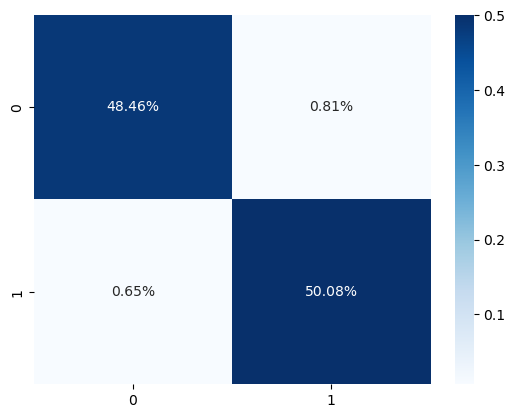

# Classification with changed testing stats

F1-score:  0.8571428571428572


<AxesSubplot: >

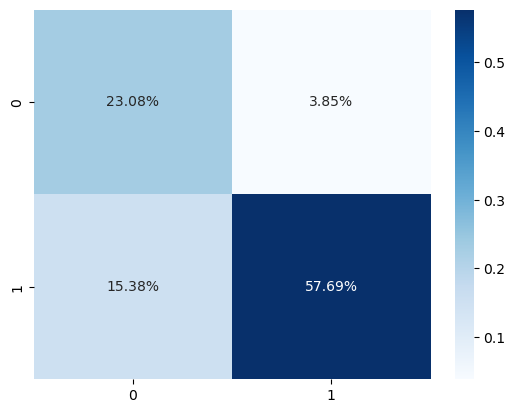

# Classification of API current match data with filled in stats

Accuracy score:  0.75
F1 score:  0.8
[[ 5  2]
 [ 3 10]]


,Player1,Player2,Result,Prediction
0,Mika Brunold,Michael Vrbensky,0,0
1,Roy Smith,Domagoj Biljesko,1,1
2,Pavel Nejedly,Abedallah Shelbayh,0,0
3,Lukas Pokorny,Daniel Rincon,0,0
4,William Jansen,Samuel Ruggeri,0,1
5,Amr Elsayed,Kelsey Stevenson,1,1
6,Jan Choinski,Julio Porras,1,1
7,Aleksandr Braynin,Pablo Carretero,1,1
8,Ryan Nijboer,Alejandro Canas,1,0
9,Remy Bertola,Ignasi Genover,1,1


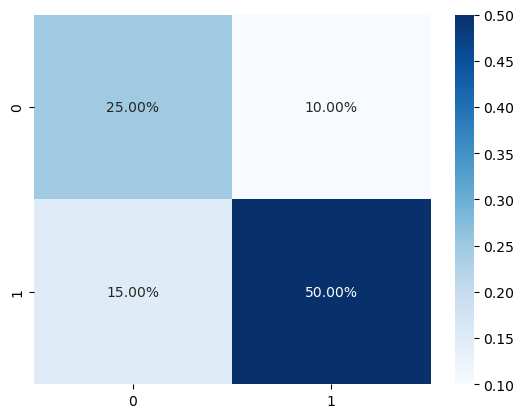